In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18424573297378791016
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 49125457920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16157019101779846799
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:00:10.0, compute capability: 8.6"
 xla_global_id: 416903419]

# ORTO TRAINING

In [ ]:
import numpy as np
import imageio
import cv2
import pandas as pd
import random

In [ ]:
size = 63

In [ ]:
import numpy as np
import imageio
import cv2
import pandas as pd
import random

batch_size = 500000
X_train = np.empty((batch_size,size,size,3), int)
y_train = np.empty((batch_size), int)

random.seed(69)

train_csv = np.loadtxt("train_cleaned.csv",
                 delimiter=",", dtype=str)

try:
  with open("ristmikud.csv") as f:
    index = 0
    for n, line in enumerate(f):
      if n%10000 == 0:
        print(n)
      pic, *cord = line.split(", ")
      if pic in train_csv:
        gif = imageio.mimread("P03_6000_train/train_orto/orto_%s.gif"%pic)
        gif = np.flip(cv2.cvtColor(gif[0], cv2.COLOR_RGB2BGR), axis=0)


        cords = []
        for i in cord:
          x, y = list(map(int, i.split("-")))
          cords.append((x,y))
          subimage = gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
          if subimage.shape[0] == size and subimage.shape[1] == size:
            X_train[index] = subimage
            y_train[index] = 1
            index += 1

        non_intersects = 50
        for x1,y1 in zip(random.sample(range(1000), non_intersects), random.sample(range(1000), non_intersects)):
          for x2,y2 in cords:
            if ((x1-x2)**2+(y1-y2)**2)**0.5 <= size//2:
              break
          else:
            subimage = gif[y1-size//2:y1+size//2+1, x1-size//2:x1+size//2+1]
            if subimage.shape[0] == size and subimage.shape[1] == size:
              X_train[index] = subimage
              y_train[index] = 0
              index += 1

except IndexError:
  print("still intersections to store")

X_train_orto = np.delete(X_train,np.s_[index:],axis=0)
y_train_orto = np.delete(y_train,np.s_[index:],axis=0)
print("ristmike arv:", index, len(X_train_orto), len(y_train_orto))


0
10000
20000
30000
ristmike arv: 205766 205766 205766


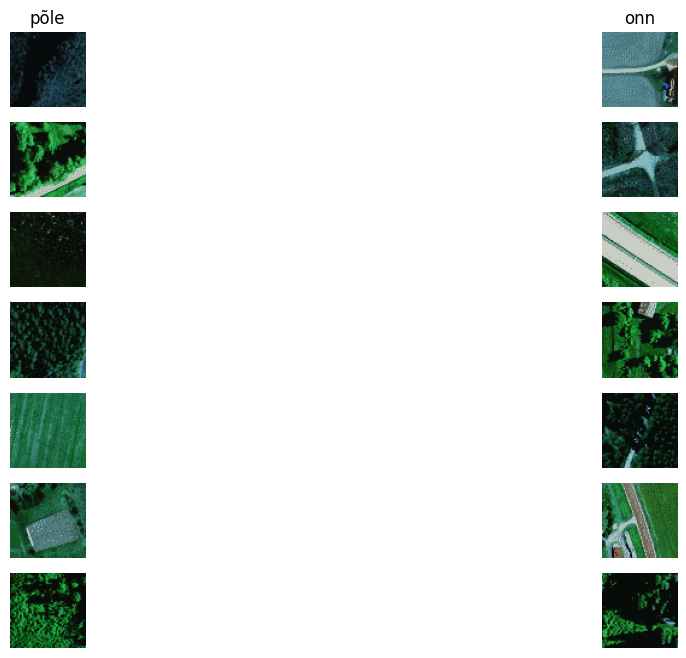

0 169246 1 36520 ratio 0.2157805797478227


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14.0, 8.0)
class_names = ["põle", "onn"]
num_classes = len(class_names)

samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train_orto == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_orto[idx].reshape((size, size, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

zeros = np.sum(y_train_orto==0)
ones = np.sum(y_train_orto==1)
print("0", zeros, "1", ones, "ratio", ones/zeros)

## Matsin learn (Machine learn)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall

x = Input(shape=(size, size, 3))
c1 = Conv2D(size, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)

c2 = Conv2D(size, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector

h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)

z = Dense(2)(d3)
p = Activation('softmax')(z)

model_orto = Model(inputs=x, outputs=p)
model_orto.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model_orto.summary()

history = model_orto.fit(X_train_orto, y_train_orto, batch_size=32, epochs=7, validation_split=0.1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 63, 63, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 63)        1764      
                                                                 
 batch_normalization (Batch  (None, 63, 63, 63)        252       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 63, 63, 63)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 63)        35784     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 63)        252       
 chNormalization)                                            

In [ ]:
model_orto.save('model_orto.keras')
del model_orto, X_train_orto, y_train_orto

In [ ]:
import gc
gc.collect()

1530

# MAP TRAINING


In [ ]:
size = 63

In [ ]:
batch_size = 500000
X_train = np.empty((batch_size,size,size,3), int)
y_train = np.empty((batch_size), int)

random.seed(69)

train_csv = np.loadtxt("train_cleaned.csv",
                 delimiter=",", dtype=str)

try:
  with open("ristmikud.csv") as f:
    index = 0
    for n, line in enumerate(f):
      if n%10000 == 0:
        print(n)
      pic, *cord = line.split(", ")
      if pic in train_csv:
        gif = imageio.mimread("P03_6000_train/train_map/map_%s.gif"%pic)
        gif = np.flip(cv2.cvtColor(gif[0], cv2.COLOR_RGB2BGR), axis=0)

        cords = []
        for i in cord:
          x, y = list(map(int, i.split("-")))
          cords.append((x,y))
          subimage = gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
          if subimage.shape[0] == size and subimage.shape[1] == size:
            X_train[index] = subimage
            y_train[index] = 1
            index += 1

        non_intersects = 50

        for x1,y1 in zip(random.sample(range(1000), non_intersects), random.sample(range(1000), non_intersects)):
          for x2,y2 in cords:
            if ((x1-x2)**2+(y1-y2)**2)**0.5 <= size//2:
              break
          else:
            subimage = gif[y1-size//2:y1+size//2+1, x1-size//2:x1+size//2+1]
            if subimage.shape[0] == size and subimage.shape[1] == size:
              X_train[index] = subimage
              y_train[index] = 0
              index += 1

except IndexError:
  print("still intersections to store")

X_train_map = np.delete(X_train,np.s_[index:],axis=0)
y_train_map = np.delete(y_train,np.s_[index:],axis=0)
print("ristmike arv:", index, len(X_train_map), len(y_train_map))


0
10000
20000
30000
ristmike arv: 205766 205766 205766


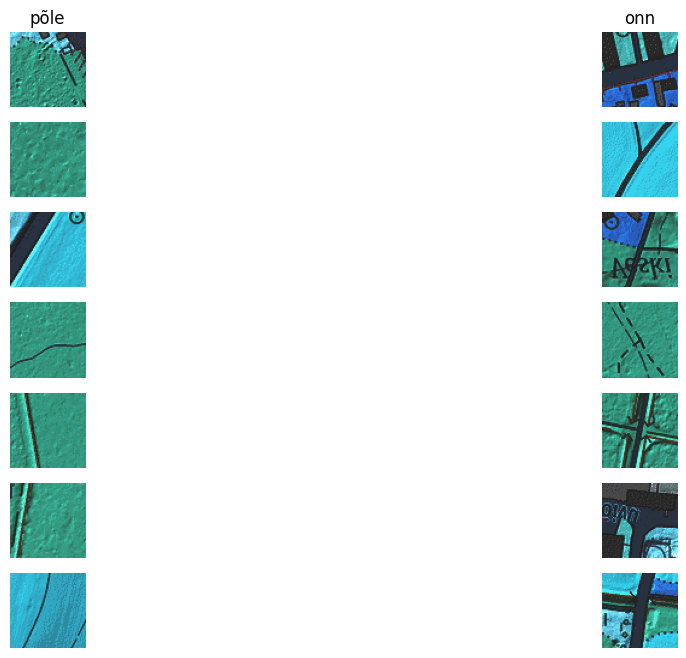

0 169246 1 36520 ratio 0.2157805797478227


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14.0, 8.0)
class_names = ["põle", "onn"]
num_classes = len(class_names)

samples_per_class = 7
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train_map == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_map[idx].reshape((size, size, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

zeros = np.sum(y_train_map==0)
ones = np.sum(y_train_map==1)
print("0", zeros, "1", ones, "ratio", ones/zeros)

## Matsin learn

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x = Input(shape=(size, size, 3))
c1 = Conv2D(size, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)

c2 = Conv2D(size, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector

h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)

z = Dense(2)(d3)
p = Activation('softmax')(z)

model_map = Model(inputs=x, outputs=p)
model_map.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model_map.summary()

history = model_map.fit(X_train_map, y_train_map, batch_size=32, epochs=7, validation_split=0.1)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 63, 63, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 63)        1764      
                                                                 
 batch_normalization_3 (Bat  (None, 63, 63, 63)        252       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 63, 63, 63)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 63)        35784     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 61, 63)        252       
 chNormalization)                                          

In [ ]:
model_map.save('model_map.keras')
del model_map, X_train_map, y_train_map

In [ ]:
import gc
gc.collect()

32003

#BLACK

In [ ]:
size = 63

In [ ]:
batch_size = 500000
X_train = np.empty((batch_size,size,size,3), int)
y_train = np.empty((batch_size), int)

random.seed(69)

train_csv = np.loadtxt("train_cleaned.csv",
                 delimiter=",", dtype=str)

try:
  with open("ristmikud.csv") as f:
    index = 0
    for n, line in enumerate(f):
      if n%10000 == 0:
        print(n)
      pic, *cord = line.split(", ")
      if pic in train_csv:
        gif = imageio.mimread("P03_6000_train/train_black/black_%s.gif"%pic)
        gif = np.flip(cv2.cvtColor(gif[0], cv2.COLOR_RGB2BGR), axis=0)

        cords = []
        for i in cord:
          x, y = list(map(int, i.split("-")))
          cords.append((x,y))
          subimage = gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
          if subimage.shape[0] == size and subimage.shape[1] == size:
            X_train[index] = subimage
            y_train[index] = 1
            index += 1

        non_intersects = 50
        for x1,y1 in zip(random.sample(range(1000), non_intersects), random.sample(range(1000), non_intersects)):
          for x2,y2 in cords:
            if ((x1-x2)**2+(y1-y2)**2)**0.5 <= size//2:
              break
          else:
            subimage = gif[y1-size//2:y1+size//2+1, x1-size//2:x1+size//2+1]
            if subimage.shape[0] == size and subimage.shape[1] == size:
              X_train[index] = subimage
              y_train[index] = 0
              index += 1

except IndexError:
  print("still intersections to store")

X_train_black = np.delete(X_train,np.s_[index:],axis=0)
y_train_black = np.delete(y_train,np.s_[index:],axis=0)
print("ristmike arv:", index, len(X_train_black), len(y_train_black))


0
10000
20000
30000
ristmike arv: 205766 205766 205766


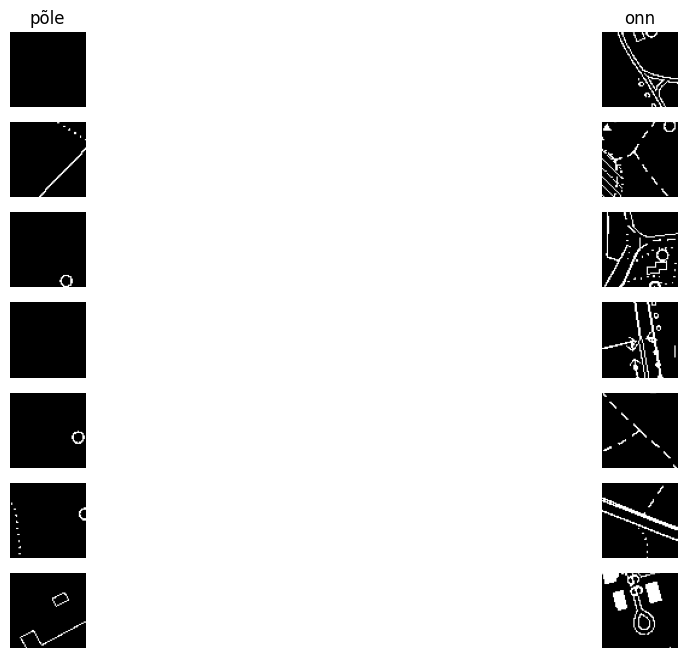

0 169246 1 36520 ratio 0.2157805797478227


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14.0, 8.0)
class_names = ["põle", "onn"]
num_classes = len(class_names)

samples_per_class = 7
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train_black == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train_black[idx].reshape((size, size, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

zeros = np.sum(y_train_black==0)
ones = np.sum(y_train_black==1)
print("0", zeros, "1", ones, "ratio", ones/zeros)

## Matsin learn

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x = Input(shape=(size, size, 3))
c1 = Conv2D(size, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)

c2 = Conv2D(size, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector

h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)

z = Dense(2)(d3)
p = Activation('softmax')(z)

model_black = Model(inputs=x, outputs=p)
model_black.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model_black.summary()

history = model_black.fit(X_train_black, y_train_black, batch_size=32, epochs=7, validation_split=0.1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 63, 63, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 63, 63, 63)        1764      
                                                                 
 batch_normalization_6 (Bat  (None, 63, 63, 63)        252       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 63, 63, 63)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 63)        35784     
                                                                 
 batch_normalization_7 (Bat  (None, 61, 61, 63)        252       
 chNormalization)                                          

In [ ]:
model_black.save('model_black.keras')
del model_black, X_train_black, y_train_black

In [ ]:
import gc
gc.collect()

29531

#Importing trained models


In [ ]:
from tensorflow.keras.models import load_model

model_map = load_model('/content/model_map.keras')
model_orto = load_model('/content/model_orto.keras')
model_black = load_model('/content/model_black.keras')

combined_model = load_model('/content/combined_model.keras')

UPPER_LIMIT = 999
size = 63

In [ ]:
import imageio
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import imageio
import cv2
import pandas as pd
import random

df_test = pd.read_csv('/content/test_gt.csv')

unique_values = df_test['image_id'].unique()
image_id = pd.Series(unique_values).sample().iloc[0]

#Testing single model predictions

In [ ]:
df_test

image_id   xmin   ymin  width  height  centerx  centery
0     376000_6474000  265.0  153.0   30.0    30.0      280      168
1     376000_6474000  244.0  235.0   30.0    30.0      259      250
2     376000_6474000  308.0  163.0   30.0    30.0      323      178
3     376000_6474000  350.0  123.0   30.0    30.0      365      138
4     376000_6474000  391.0   82.0   30.0    30.0      406       97
...              ...    ...    ...    ...     ...      ...      ...
7040  717000_6427000  259.0  515.0   30.0    30.0      274      530
7041  717000_6427000  293.0  640.0   30.0    30.0      308      655
7042  717000_6427000  232.0  745.0   30.0    30.0      247      760
7043  717000_6427000  281.0  773.0   30.0    30.0      296      788
7044  717000_6579000  457.0  643.0   30.0    30.0      472      658

[7045 rows x 7 columns]

958/958 [==============================] - 2s 2ms/step


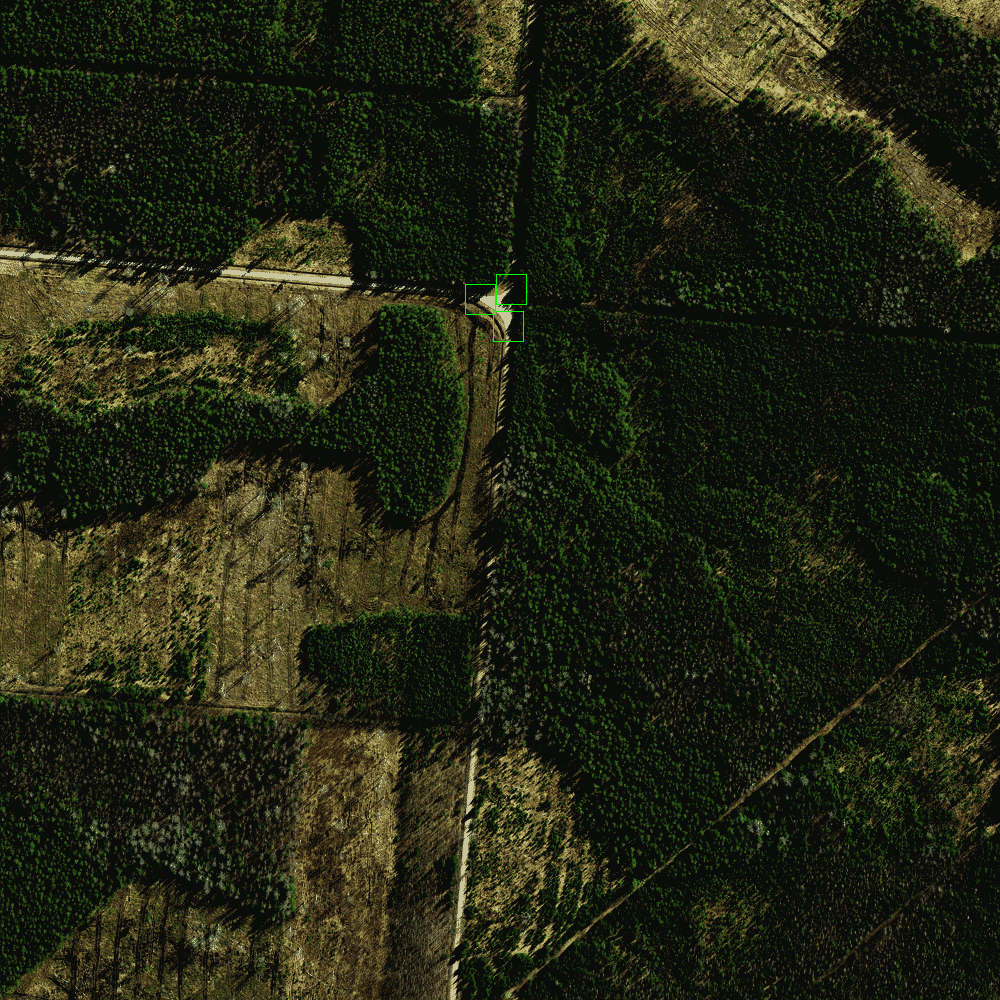

In [ ]:
test_gif = imageio.mimread(f"/content/P03_1000_test/test_orto/orto_{image_id}.gif")

test_gif = np.flip(cv2.cvtColor(test_gif[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

cords = [(x, y) for y in range(size, 1000-size, 5) for x in range(size,1000-size,5)]
grid = np.zeros((len(cords),size,size,3), int)
index = 0
for x, y in cords:
  subimage = test_gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  if subimage.shape[0] == size and subimage.shape[1] == size:
    grid[index] = subimage #np.concatenate((grid, [subimage]))
    index += 1

prediction_orto = model_orto.predict(grid)

img = test_gif.copy()
for (pred_0, pred_1), (x, y) in zip(prediction_orto, cords):
  if pred_1>=0.99: #predict accept thrshold
      cv2.circle(img, (x, y), 3, (0, 0, 255), -1)


filtered_rows = df_test[df_test['image_id'] == image_id]

for index, row in filtered_rows.iterrows():

    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    width = int(row['width'])
    height = int(row['height'])

    cv2.rectangle(img, (xmin, ymin), (xmin + width, ymin + width), (0, 255, 0), 1)

cv2_imshow(img)

958/958 [==============================] - 2s 2ms/step


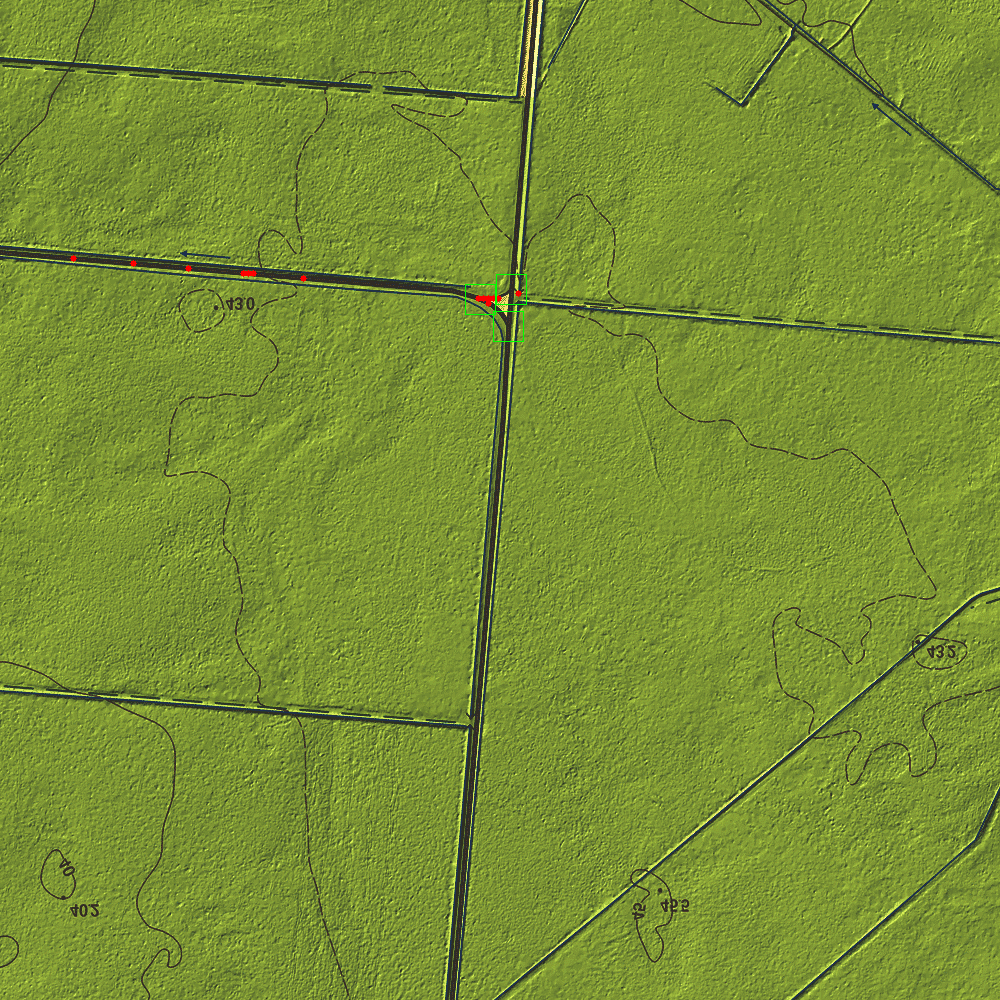

In [ ]:
test_gif = imageio.mimread(f"/content/P03_1000_test/test_map/map_{image_id}.gif")

test_gif = np.flip(cv2.cvtColor(test_gif[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

cords = [(x, y) for y in range(size, 1000-size, 5) for x in range(size,1000-size,5)]
grid = np.zeros((len(cords),size,size,3), int)
index = 0

for x, y in cords:
  subimage = test_gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  if subimage.shape[0] == size and subimage.shape[1] == size:
    grid[index] = subimage #np.concatenate((grid, [subimage]))
    index += 1

prediction_map = model_map.predict(grid)

img = test_gif.copy()
for (pred_0, pred_1), (x, y) in zip(prediction_map, cords):
  if pred_1>=0.99: #predict accept thrshold
      cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

filtered_rows = df_test[df_test['image_id'] == image_id]

for index, row in filtered_rows.iterrows():

    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    width = int(row['width'])
    height = int(row['height'])

    cv2.rectangle(img, (xmin, ymin), (xmin + width, ymin + width), (0, 255, 0), 1)

cv2_imshow(img)

958/958 [==============================] - 2s 2ms/step


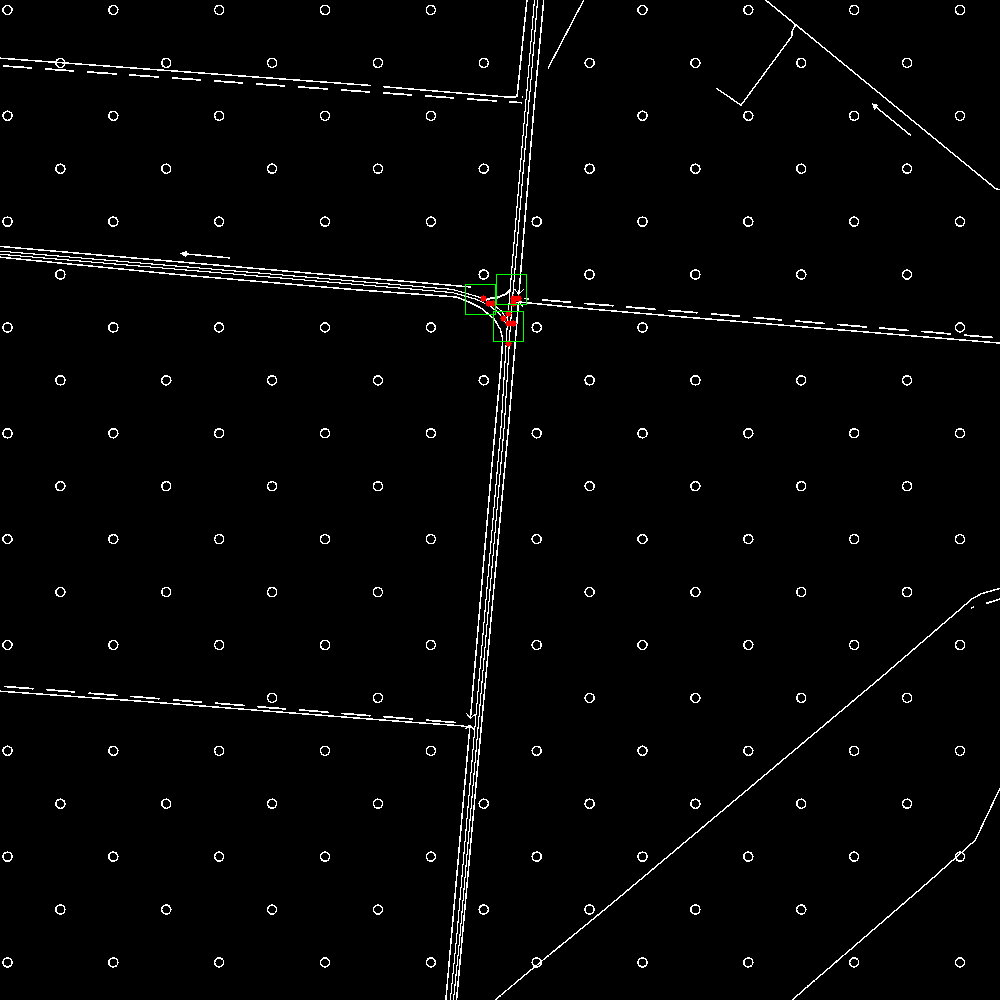

In [ ]:
test_gif = imageio.mimread(f"/content/P03_1000_test/test_black/black_{image_id}.gif")

test_gif = np.flip(cv2.cvtColor(test_gif[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

cords = [(x, y) for y in range(size, 1000-size, 5) for x in range(size,1000-size,5)]
grid = np.zeros((len(cords),size,size,3), int)
index = 0
for x, y in cords:
  subimage = test_gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  if subimage.shape[0] == size and subimage.shape[1] == size:
    grid[index] = subimage #np.concatenate((grid, [subimage]))
    index += 1

prediction_black = model_black.predict(grid)

img = test_gif.copy()
for (pred_0, pred_1), (x, y) in zip(prediction_black, cords):
  if pred_1>=0.99: #predict accept thrshold
      cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

filtered_rows = df_test[df_test['image_id'] == image_id]

for index, row in filtered_rows.iterrows():

    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    width = int(row['width'])
    height = int(row['height'])

    cv2.rectangle(img, (xmin, ymin), (xmin + width, ymin + width), (0, 255, 0), 1)

cv2_imshow(img)

#Training a combined model

We used only map and black images as orto gave such horrible results.

In [ ]:
batch_size = 200000
X_train_map = np.empty((batch_size,size,size,3), int)
X_train_black = np.empty((batch_size,size,size,3), int)
y_train = np.empty((batch_size), int)

random.seed(69)

train_csv = np.loadtxt("train_cleaned.csv",
                 delimiter=",", dtype=str)
try:
  with open("ristmikud.csv") as f:
    index = 0
    for n, line in enumerate(f):
      if n%10000 == 0:
        print(n)
      pic, *cord = line.split(", ")

      if pic in train_csv:

        gif_black = imageio.mimread("P03_6000_train/train_black/black_%s.gif"%pic)
        gif_black = np.flip(cv2.cvtColor(gif_black[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below
        gif_map = imageio.mimread("P03_6000_train/train_map/map_%s.gif"%pic)
        gif_map = np.flip(cv2.cvtColor(gif_map[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

        cords = []
        for i in cord:
          x, y = list(map(int, i.split("-")))
          cords.append((x,y))
          subimage_black = gif_black[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
          if subimage_black.shape[0] == size and subimage_black.shape[1] == size:

            subimage_map = gif_map[y-size//2:y+size//2+1, x-size//2:x+size//2+1]

            X_train_black[index] = subimage_black
            X_train_map[index] = subimage_map
            y_train[index] = 1
            if index % 100 == 0:
              print(f"Index: {index}")
            index += 1

        non_intersects = 50

        for x1,y1 in zip(random.sample(range(1000), non_intersects), random.sample(range(1000), non_intersects)):
          for x2,y2 in cords:
            if ((x1-x2)**2+(y1-y2)**2)**0.5 <= size//2:
              break
          else:

            subimage_black = gif_black[y1-size//2:y1+size//2+1, x1-size//2:x1+size//2+1]
            subimage_map = gif_map[y1-size//2:y1+size//2+1, x1-size//2:x1+size//2+1]

            if subimage_black.shape[0] == subimage_map.shape[0] == size and subimage_black.shape[1] == subimage_map.shape[1] == size:


              X_train_black[index] = subimage_black
              X_train_map[index] = subimage_map
              y_train[index] = 0
              index += 1

except IndexError:
  print("still intersections to store")

X_train_black = np.delete(X_train_black,np.s_[index:],axis=0)
X_train_map = np.delete(X_train_map,np.s_[index:],axis=0)
y_train = np.delete(y_train,np.s_[index:],axis=0)

0
10000
20000
30000
still intersections to store


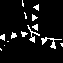

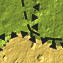

1
200000


In [ ]:
idx = 0

cv2_imshow(X_train_black[idx])
cv2_imshow(X_train_map[idx])
print(y_train[idx])
print(len(y_train))

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input2 = Input(shape=(size, size, 3))
input3 = Input(shape=(size, size, 3))

output_map = model_map(input2)
output_black = model_black(input3)

merged_output = Concatenate()([output_map, output_black])

shared_layer = Dense(128, activation='relu')(merged_output)
output_layer = Dense(2, activation='softmax')(shared_layer)

combined_model = Model(inputs=[input2, input3], outputs=output_layer)

combined_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
combined_model.summary()

history = combined_model.fit([X_train_map, X_train_black], y_train, epochs=4, batch_size=16, validation_split=0.1)
combined_model.save('combined_model.keras')

#Predicting with the combined model


In [ ]:
image_id = pd.Series(unique_values).sample().iloc[0]

In [ ]:
image_id = '560000_6455000'

958/958 [==============================] - 4s 4ms/step


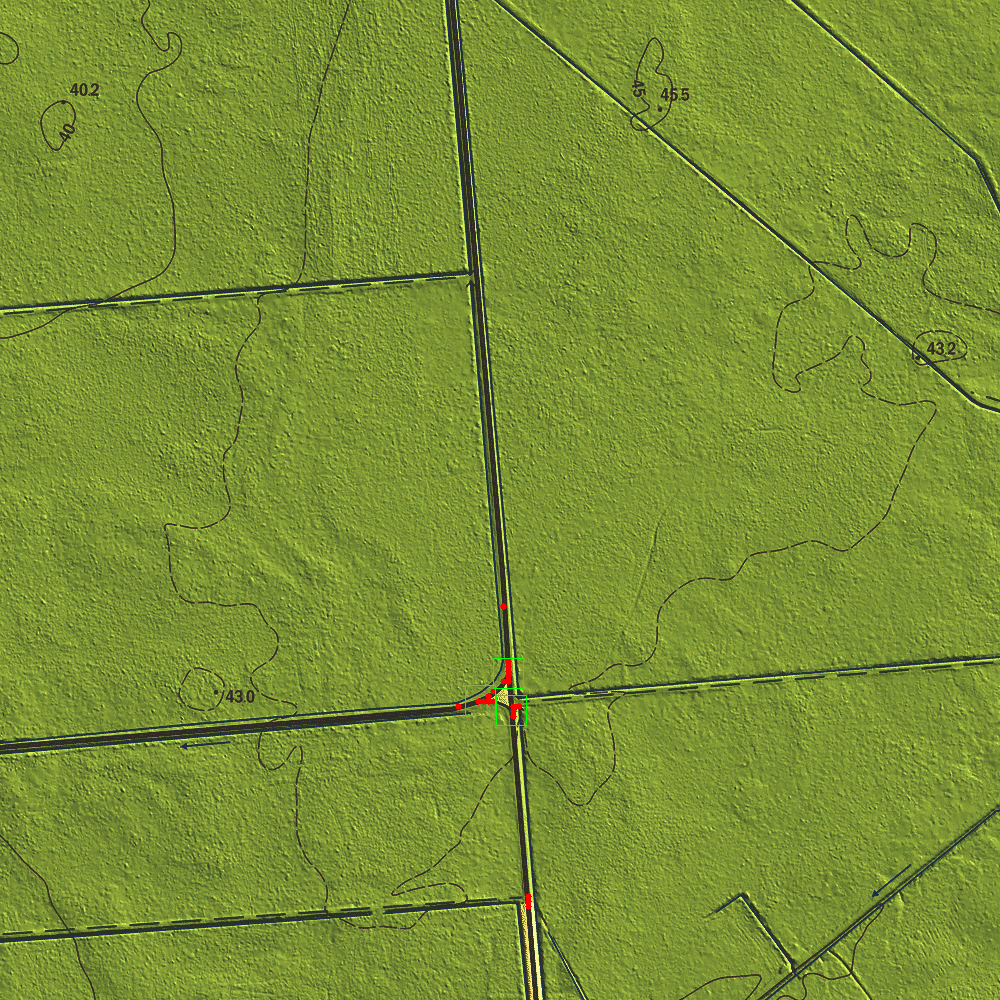

In [ ]:
gif_black = imageio.mimread(f"/content/P03_1000_test/test_black/black_{image_id}.gif")
gif_map = imageio.mimread(f"/content/P03_1000_test/test_map/map_{image_id}.gif")
gif_orto = imageio.mimread(f"/content/P03_1000_test/test_orto/orto_{image_id}.gif")

gif_black = np.flip(cv2.cvtColor(gif_black[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below
gif_map = np.flip(cv2.cvtColor(gif_map[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below
gif_orto = np.flip(cv2.cvtColor(gif_orto[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

cords = [(x, y) for y in range(size, 1000-size, 5) for x in range(size,1000-size,5)]

grid_black = np.zeros((len(cords),size,size,3), int)
grid_map = np.zeros((len(cords),size,size,3), int)
#grid_orto = np.zeros((len(cords),size,size,3), int)

index = 0

for x, y in cords:

  subimage_black = gif_black[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  subimage_map = gif_map[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  #subimage_orto = gif_orto[y-size//2:y+size//2+1, x-size//2:x+size//2+1]

  if subimage_black.shape[0] == size and subimage_black.shape[1] == size:
    grid_black[index] = subimage_black #np.concatenate((grid, [subimage]))
    grid_map[index] = subimage_map
    #grid_orto[index] = subimage_orto
    index += 1

prediction_map = combined_model.predict([grid_map, grid_black])

img = gif_map.copy()
for (pred_0, pred_1), (x, y) in zip(prediction_map, cords):
  if pred_1>=0.99: #predict accept thrshold
      cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

filtered_rows = df_test[df_test['image_id'] == image_id]

for index, row in filtered_rows.iterrows():

    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    width = int(row['width'])
    height = int(row['height'])

    cv2.rectangle(img, (xmin, ymin), (xmin + width, ymin + width), (0, 255, 0), 1)

img = cv2.flip(img, 0)

cv2_imshow(img)

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()